# Scenario Discovery with PRIM on 2D Barbell (λ = 0.05)

## Imports

In [1]:
import matplotlib.pyplot as plt
from ema_workbench.analysis.prim import Prim
from src.load_shapes import load_shape_dataset

## Load and Show Benchmark Problem

 We load the 2D Barbell benchmark problem with boundary noise λ = 0.05.

In [2]:
# Load and unpack a specific dataset
dataset_name = "barbell_2d_label_noise_005"
X, y = load_shape_dataset(folder_name="shapes")[dataset_name]


Loaded 32 paired datasets: ['barbell_2d_label_noise_000', 'barbell_3d_label_noise_000', 'radial_segment_2d_label_noise_000', 'radial_segment_3d_label_noise_000', 'rectangle_2d_label_noise_000', 'saddle_3d_label_noise_000', 'sine_wave_2d_label_noise_000', 'star_2d_label_noise_000', 'barbell_2d_label_noise_003', 'barbell_3d_label_noise_003', 'radial_segment_2d_label_noise_003', 'radial_segment_3d_label_noise_003', 'rectangle_2d_label_noise_003', 'saddle_3d_label_noise_003', 'sine_wave_2d_label_noise_003', 'star_2d_label_noise_003', 'barbell_2d_label_noise_005', 'barbell_3d_label_noise_005', 'radial_segment_2d_label_noise_005', 'radial_segment_3d_label_noise_005', 'rectangle_2d_label_noise_005', 'saddle_3d_label_noise_005', 'sine_wave_2d_label_noise_005', 'star_2d_label_noise_005', 'barbell_2d_label_noise_007', 'barbell_3d_label_noise_007', 'radial_segment_2d_label_noise_007', 'radial_segment_3d_label_noise_007', 'rectangle_2d_label_noise_007', 'saddle_3d_label_noise_007', 'sine_wave_2d_

Before applying PRIM, we first visualise the input dataset to understand its geometric structure and the location of the class 1 points that PRIM will aim to capture.

This plot shows the distribution of points in the 2D input space:
- Blue points: class 0 (non-target region)
- Orange points: class 1 (target region that PRIM will attempt to cover)

Visualising the data upfront is particularly important for scenario discovery methods, as it provides an intuitive sense of whether the problem is likely to require multiple boxes.

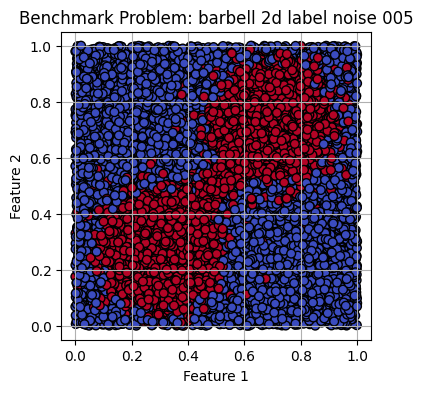

In [3]:
# Plot the dataset
plt.figure(figsize=(4, 4))
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=40)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f"Benchmark Problem: {dataset_name.replace('_', ' ')}")
plt.grid(True)
plt.show()

## Configure PRIM Parameters

In [4]:
# PRIM configuration
mass_min = 0.05        # Minimum fraction of total data required in each valid box
threshold = 0.8        # Required density: only boxes with density >= 0.8 are accepted
peel_alpha = 0.05      # Fraction of mass removed at each peel step (controls peeling speed)
paste_alpha = 0.05     # Fraction of mass added back during pasting (controls pasting sensitivity)

## Set-Up PRIM

We initialise PRIM with the *Guivarch update function* (`update_function='guivarch'`), following the approach of Guivarch et al. (2016).  
This modifies PRIM’s behaviour after each box is found:

- **Only the class 1 points already covered by the current box are excluded** (their labels are set to 0).  
- All other data points, including class 0 points and uncovered class 1 points, remain in the dataset.  
- The algorithm can then continue to discover **diverse, non-overlapping boxes** in subsequent iterations.

We select this option because we explicitly aim to find **multiple boxes** that together explain different regions of the target scenario subset (class 1). This is essential when the target set may be fragmented or defined by multiple distinct subspaces.

In [5]:
# Train PRIM
prim = Prim(
    X,
    y,
    threshold=threshold,
    peel_alpha=peel_alpha,
    paste_alpha=paste_alpha,
    mass_min=mass_min,
    update_function='guivarch',
)

## Finding the First Box
First let us run the algorithm to identify the first box.

In [6]:
box1 = prim.find_box()

### Visualise Coverage-Density Trade-off (First Box)

The trade-off plot visualises candidate boxes found by PRIM along the coverage-density spectrum:

- Each point represents one candidate box evaluated during the peeling and pasting process.
- Moving right increases **coverage** (fraction of target points captured), but often lowers **density** (purity of the box).

This plot is the primary tool for selecting which box to retain.

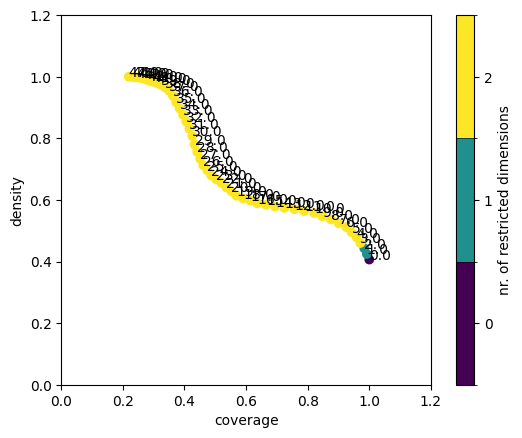

In [7]:
# Visualize the trade-off between coverage and density
box1.show_tradeoff(annotated=True)
plt.show()

The **trade-off plot** reveals an important insight about this particular benchmark problem.

Because the Barbell shape consists of **two separate circular regions** connected by a narrow handle, it is inherently difficult for a *single box* to achieve both high coverage and high density. We observe this behaviour in the trade-off curve:

- At the **bottom right** of the plot, the algorithm achieves high coverage, but density remains low. This is because a single box must cover both bells and the handle, including many class 0 points in between.
- Towards the **upper left**, smaller boxes achieve much higher density by focusing on only one of the circular regions, this does therefore translate in lower coverage values.

This behaviour is expected given the **geometry of the target class**. The optimal strategy here is therefore to accept lower coverage per box, but find **multiple boxes** that together cover the target regions effectively:

- Typically, two boxes are sufficient to cover the two bells with high density.
- Optionally, a third box can be added to capture the handle if desired.

### List of Candidate Boxes

To support this selection, we next print the full peeling trajectory too.  
This is useful because the trade-off plots annotate creates overlapping labels.  
We will use this table to select which box to keep based on its coverage and density value.

In [8]:
# Show a table of the peeling trajectory
box1.peeling_trajectory

,coverage,density,id,k,mass,mean,n,res_dim
0,1.000000,0.406400,0,4064,1.0000,0.406400,10000,0
1,0.992126,0.424421,1,4032,0.9500,0.424421,9500,1
2,0.983760,0.442992,2,3998,0.9025,0.442992,9025,1
3,0.970965,0.460282,3,3946,0.8573,0.460282,8573,2
4,0.958907,0.478512,4,3897,0.8144,0.478512,8144,2
5,0.942421,0.495088,5,3830,0.7736,0.495088,7736,2
6,0.925443,0.511770,6,3761,0.7349,0.511770,7349,2
7,0.900591,0.524280,7,3660,0.6981,0.524280,6981,2
8,0.875492,0.536571,8,3558,0.6631,0.536571,6631,2
9,0.847441,0.546753,9,3444,0.6299,0.546753,6299,2


### Select First Box

Based on the coverage-density trade-off plot and the printed list of candidate boxes, we select **Box 37** as the first retained box.

- It achieves a **coverage of ≈ 0.35**, which is consistent with the expectation that each bell in the Barbell shape contains ≈ 30-40% of the class 1 points.
- It also achieves a **density of ≈ 0.95**, indicating that the box is quite pure.
- Boxes with higher coverage (further right on the plot) suffer from rapidly decreasing density, as they must include parts of both bells and the handle, reducing interpretability.

We now select Box 37 as our first box:


In [9]:
# Box 37 is chosen based on the plot above
best_box_index_1 = 37

### Inspect Selected Box

We now inspect the contents of the selected box (Box 37) in more detail:

- The **box inspection plot** shows the numerical constraints on each restricted input dimension (here: the two spatial features).
- The **pairwise scatter plot** visualises how the selected box covers the target class in the 2D input space.

Together, these visualisations allow us to verify whether the box indeed isolates one of the Barbell's circular regions, with minimal overlap onto the other bell or the connecting handle.

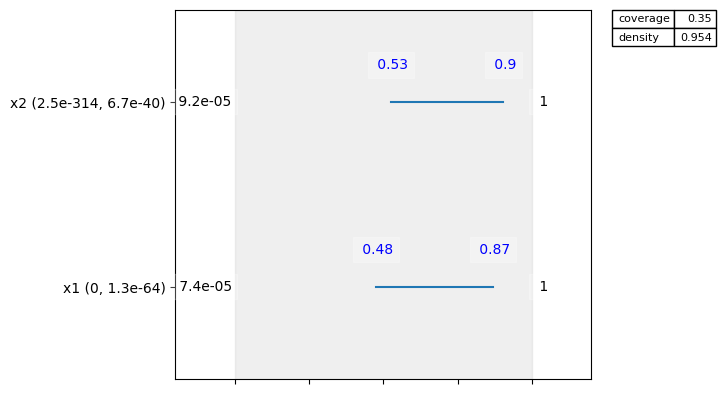

In [10]:
# Show box inspection plot
box1.inspect(best_box_index_1, style="graph")
plt.show()

# # Show pairwise scatter plot for the best PRIM box
# box1.show_pairs_scatter(i=best_box_index_1)
# plt.show()

### Interpretation of Selected Box

The selected box (Box 37) successfully isolates the **top-right circular region** of the Barbell shape:

- The pairwise scatter plot clearly shows that the box bounds enclose the upper right cluster of class 1 points.
- Importantly, the box avoids extending into the left bell or the narrow handle region, which would have reduced density.

This result is fully consistent with the geometry of the benchmark problem. Since the Barbell consists of **two separate target regions**, we next proceed to search for a **second box** to capture the remaining target region (bottom-left bell).

## Finding the Second Box

We now run PRIM again to identify a second box.  
Because we used the *Guivarch update function*, the first box already excluded the class 1 points it covered.

This means that the second call to `find_box()` will target the remaining class 1 points, in this case, the **bottom-left bell** of the Barbell shape.


In [11]:
# Find second box
box2 = prim.find_box()

### Visualise Coverage-Density Trade-off (Second Box)

We again inspect the coverage-density trade-off to select a suitable box.

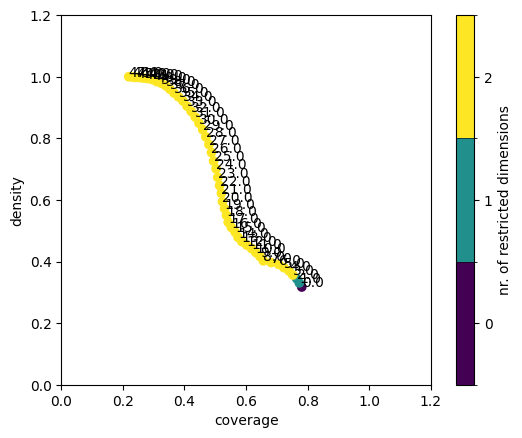

,coverage,density,id,k,mass,mean,n,res_dim
0,0.780758,0.317300,0,3173,1.0000,0.317300,10000,0
1,0.772884,0.330632,1,3141,0.9500,0.330632,9500,1
2,0.764518,0.344266,2,3107,0.9025,0.344266,9025,1
3,0.751722,0.356351,3,3055,0.8573,0.356351,8573,2
4,0.739665,0.369106,4,3006,0.8144,0.369106,8144,2
5,0.723179,0.379912,5,2939,0.7736,0.379912,7736,2
6,0.706201,0.390529,6,2870,0.7349,0.390529,7349,2
7,0.681348,0.396648,7,2769,0.6981,0.396648,6981,2
8,0.656250,0.402202,8,2667,0.6631,0.402202,6631,2
9,0.645177,0.416257,9,2622,0.6299,0.416257,6299,2


In [12]:
# Visualize the trade-off between coverage and density for box2
box2.show_tradeoff(annotated=True)
plt.show()

# Show a table of the peeling trajectory
box2.peeling_trajectory

### Select Second Box

Based on the second trade-off plot and the printed list of candidate boxes, we select **Box 37** again as the best candidate:

- The box achieves a high **density (~0.95)** and moderate **coverage (~0.35)**, consistent with the remaining target region.
- As with the first box, higher coverage values degrade density due to the handle or scattered points.

We now select Box 37 as our second retained box.

In [13]:
# Box 37 is chosen based on the plot above
best_box_index_2 = 37

### Inspect Selected Second Box

We next inspect Box 37 from the second PRIM run to verify that it correctly captures the remaining target region (bottom-left bell).

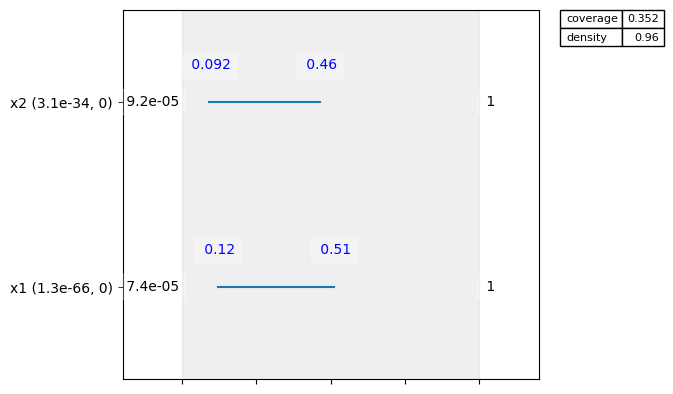

In [14]:
# Show box inspection plot
box2.inspect(best_box_index_2, style="graph")
plt.show()

# # Show pairwise scatter plot for the best PRIM box
# box2.show_pairs_scatter(i=best_box_index_2)
# plt.show()

### Interpretation of Selected Second Box

The selected second box (Box 37) successfully isolates the **bottom-left circular region** of the Barbell shape:

- The pairwise scatter plot shows that the box bounds enclose the lower left cluster of class 1 points.
- There is minimal leakage into the upper bell or the handle.

## Finding the Third Box

Finally, we run PRIM a third time to see if a **third box** can further improve total coverage.

At this stage:

- The two bells have been mostly covered.
- Remaining target points (class 1) are likely located in the **handle region** or are scattered near the boundaries.

If a third box is identified with acceptable density, it can optionally be added to improve completeness of the scenario set.

In [15]:
# Find third box
box3 = prim.find_box()

### Visualise Coverage-Density Trade-off (Third Box)

We now inspect the coverage-density trade-off to evaluate whether a third box can still be meaningfully retained.

Based on the problem’s geometry and prior results, we expect that after covering approximately **70%** of the target class with two high-density boxes, the remaining points will be primarily located in the narrow handle region of the Barbell or scattered near the noisy edges of the circular regions. These residual points are sparse and often intermixed with class 0 observations, making it challenging to isolate a coherent and pure additional box.

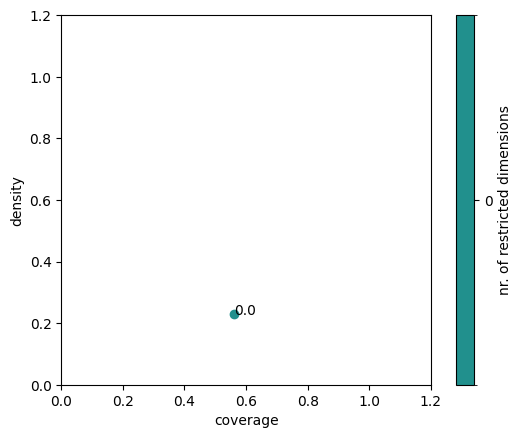

,coverage,density,id,k,mass,mean,n,res_dim
0,0.561516,0.2282,0,2282,1.0,0.2282,10000,0


In [16]:
# Visualize the trade-off between coverage and density for box3
box3.show_tradeoff(annotated=True)
plt.show()

# Show a table of the peeling trajectory
box3.peeling_trajectory

## Interpretation of Third Box Attempt

In practice, the trade-off plot and peeling trajectory confirm that **no third box meeting the minimum density threshold of 0.8 and minimum mass threshold of 5% was found**. The remaining target points are too dispersed and mixed with non-target points to form a sufficiently large and pure box.

This outcome reflects the intrinsic structure of the Barbell benchmark: the two previously selected boxes effectively capture the core target regions (the two “bells”). Attempting to add more boxes would mainly include noisy or ambiguous regions, thereby reducing interpretability.

Therefore, retaining two well-chosen boxes provides a clear and meaningful scenario description for this problem. Including additional boxes risks lowering the clarity and practical utility of the scenario discovery.

## Box Evaluation

In [17]:
from E_hhcart_d_vs_established_methods_on_synthetic_data.visualisation_prim_cart_pca_prim.box_plotter import plot_boxes

In [18]:
# Load and unpack a specific dataset
dataset_name = "barbell_2d_label_noise_005"
X, y = load_shape_dataset(folder_name="shapes")[dataset_name]

# Feature names (your X.columns) -- required because PRIM sometimes rotates features
feature_names = X.columns.tolist()

# Selected box indices (for PRIM you must pass them)
selected_indices = [best_box_index_1, best_box_index_2]


Loaded 32 paired datasets: ['barbell_2d_label_noise_000', 'barbell_3d_label_noise_000', 'radial_segment_2d_label_noise_000', 'radial_segment_3d_label_noise_000', 'rectangle_2d_label_noise_000', 'saddle_3d_label_noise_000', 'sine_wave_2d_label_noise_000', 'star_2d_label_noise_000', 'barbell_2d_label_noise_003', 'barbell_3d_label_noise_003', 'radial_segment_2d_label_noise_003', 'radial_segment_3d_label_noise_003', 'rectangle_2d_label_noise_003', 'saddle_3d_label_noise_003', 'sine_wave_2d_label_noise_003', 'star_2d_label_noise_003', 'barbell_2d_label_noise_005', 'barbell_3d_label_noise_005', 'radial_segment_2d_label_noise_005', 'radial_segment_3d_label_noise_005', 'rectangle_2d_label_noise_005', 'saddle_3d_label_noise_005', 'sine_wave_2d_label_noise_005', 'star_2d_label_noise_005', 'barbell_2d_label_noise_007', 'barbell_3d_label_noise_007', 'radial_segment_2d_label_noise_007', 'radial_segment_3d_label_noise_007', 'rectangle_2d_label_noise_007', 'saddle_3d_label_noise_007', 'sine_wave_2d_

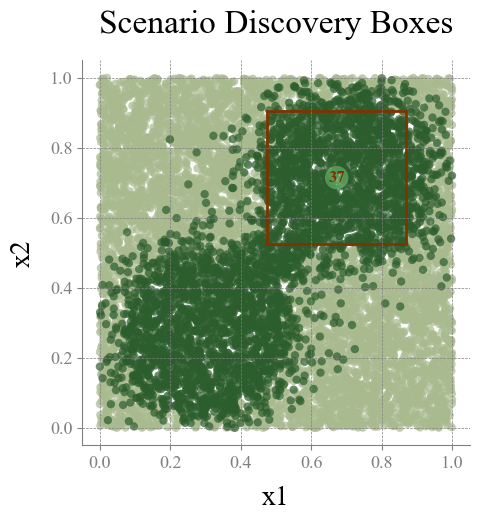

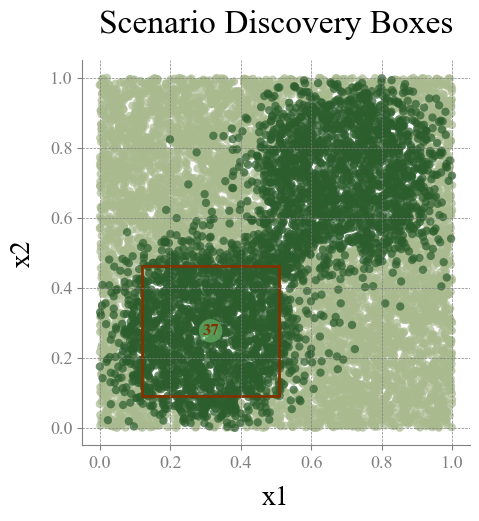

<Axes: title={'center': 'Scenario Discovery Boxes'}, xlabel='x1', ylabel='x2'>

In [19]:
plot_boxes(box1, X=X, y=y, selected_indices=[best_box_index_1], feature_names=feature_names)
plot_boxes(box2, X=X, y=y, selected_indices=[best_box_index_2], feature_names=feature_names)